# Análise Exploratória de Dados (EDA) - WIDER FACE para YOLOv8

Este notebook realiza uma análise exploratória no dataset WIDER FACE após a conversão das anotações para o formato YOLO. O objetivo é extrair insights sobre a distribuição de tamanhos, proporções e outras características das faces para informar e otimizar o treinamento do modelo YOLOv8.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuração para os plots ficarem melhores
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Magic command para mostrar os plots diretamente no notebook
%matplotlib inline

In [4]:
# --- CONFIGURE OS CAMINHOS AQUI ---
BASE_DATA_PATH = "data"

# Vamos analisar o conjunto de treino
LABELS_DIR = os.path.join(BASE_DATA_PATH, "WIDER_train", "labels")
IMAGES_DIR = os.path.join(BASE_DATA_PATH, "WIDER_train", "images")

# Verifica se os caminhos existem
if not os.path.exists(LABELS_DIR) or not os.path.exists(IMAGES_DIR):
    print("ERRO: Verifique se os caminhos para os diretórios de labels e imagens estão corretos.")
    print(f"Caminho de labels esperado: {LABELS_DIR}")
    print(f"Caminho de imagens esperado: {IMAGES_DIR}")

ERRO: Verifique se os caminhos para os diretórios de labels e imagens estão corretos.
Caminho de labels esperado: data\WIDER_train\labels
Caminho de imagens esperado: data\WIDER_train\images


## 1. Carregamento e Processamento dos Dados

Agora, vamos definir uma função para ler todos os arquivos de anotação `.txt` do formato YOLO. A função irá desnormalizar as coordenadas para obter as dimensões reais das caixas delimitadoras em pixels, o que é necessário para a nossa análise.

In [3]:
def load_yolo_data(labels_dir, images_dir):
    """
    Carrega os dados de anotação do formato YOLO.
    Esta versão primeiro mapeia todos os caminhos de imagem para garantir que os arquivos sejam encontrados.
    """
    print("Mapeando todos os caminhos de imagem. Isso pode levar um momento...")
    # Cria um dicionário que mapeia o nome do arquivo de imagem ao seu caminho completo
    # Ex: {'0_Parade_marchingband_1_100.jpg': 'data/WIDER_train/images/0--Parade/0_Parade_marchingband_1_100.jpg'}
    image_path_map = {}
    for root, _, files in os.walk(images_dir):
        for file in files:
            if file.endswith('.jpg'):
                image_path_map[file] = os.path.join(root, file)
    print(f"Mapeamento concluído. {len(image_path_map)} imagens encontradas.")

    data = []
    label_files = [f for f in os.listdir(labels_dir) if f.endswith('.txt')]

    for label_file in tqdm(label_files, desc="Processando arquivos de label"):
        image_file_name = label_file.replace('.txt', '.jpg')
        
        # Procura o caminho da imagem no mapa pré-construído
        image_path = image_path_map.get(image_file_name)
        
        if not image_path:
            # Pula se o label não tiver uma imagem correspondente no mapa
            continue

        try:
            img = cv2.imread(image_path)
            if img is None: continue
            img_h, img_w, _ = img.shape
        except Exception:
            continue

        with open(os.path.join(labels_dir, label_file), 'r') as f:
            lines = f.readlines()
            if not lines: continue
                
            for line in lines:
                parts = line.strip().split()
                # A anotação YOLO é: class x_center y_center width height
                w_norm, h_norm = map(float, parts[3:5])
                
                data.append({
                    'image_file': image_file_name,
                    'width_pixel': w_norm * img_w,
                    'height_pixel': h_norm * img_h
                })
    
    if not data:
        print("\n[Conclusão] A lista de dados final ainda está vazia. Verifique se os nomes dos arquivos .jpg e .txt correspondem.")
    
    return pd.DataFrame(data)

In [4]:
df = load_yolo_data(LABELS_DIR, IMAGES_DIR)
df.head()

Mapeando todos os caminhos de imagem. Isso pode levar um momento...
Mapeamento concluído. 12880 imagens encontradas.


Processando arquivos de label:   2%|▏         | 201/12876 [00:05<05:47, 36.52it/s]


KeyboardInterrupt: 

## 2. Análise Estatística

Com os dados carregados em um DataFrame, podemos calcular facilmente as estatísticas descritivas. Vamos adicionar colunas para `área` e `proporção` (aspect ratio) para uma análise mais rica.

In [ ]:
# Calcula métricas derivadas
df['area'] = df['width_pixel'] * df['height_pixel']
df['aspect_ratio'] = df['width_pixel'] / df['height_pixel']

print("--- Análise Estatística do Dataset ---")
print(f"Total de Imagens com Anotações Válidas: {df['image_file'].nunique()}")
print(f"Total de Faces (Bounding Boxes): {len(df)}")
print("\n--- Estatísticas Descritivas das Faces (em pixels) ---")

# Exibe as estatísticas descritivas
df[['width_pixel', 'height_pixel', 'area', 'aspect_ratio']].describe()

--- Análise Estatística do Dataset ---
Total de Imagens com Anotações Válidas: 12876
Total de Faces (Bounding Boxes): 156994

--- Estatísticas Descritivas das Faces (em pixels) ---


,width_pixel,height_pixel,area,aspect_ratio
count,156994.000000,156994.000000,1.569940e+05,156994.000000
mean,29.312394,37.876588,3.910256e+03,0.799691
std,46.531021,61.453973,2.325094e+04,0.165040
min,1.000000,1.000000,2.000000e+00,0.076923
25%,9.000000,12.000000,1.100000e+02,0.705882
50%,16.000000,20.000000,3.200000e+02,0.785714
75%,30.000000,38.000000,1.152000e+03,0.875000
max,976.000000,1289.000000,1.096939e+06,5.000000


## 3. Visualização dos Dados

Gráficos são a melhor forma de entender a distribuição dos dados. Vamos plotar histogramas e um gráfico de dispersão para visualizar as características das caixas delimitadoras das faces.

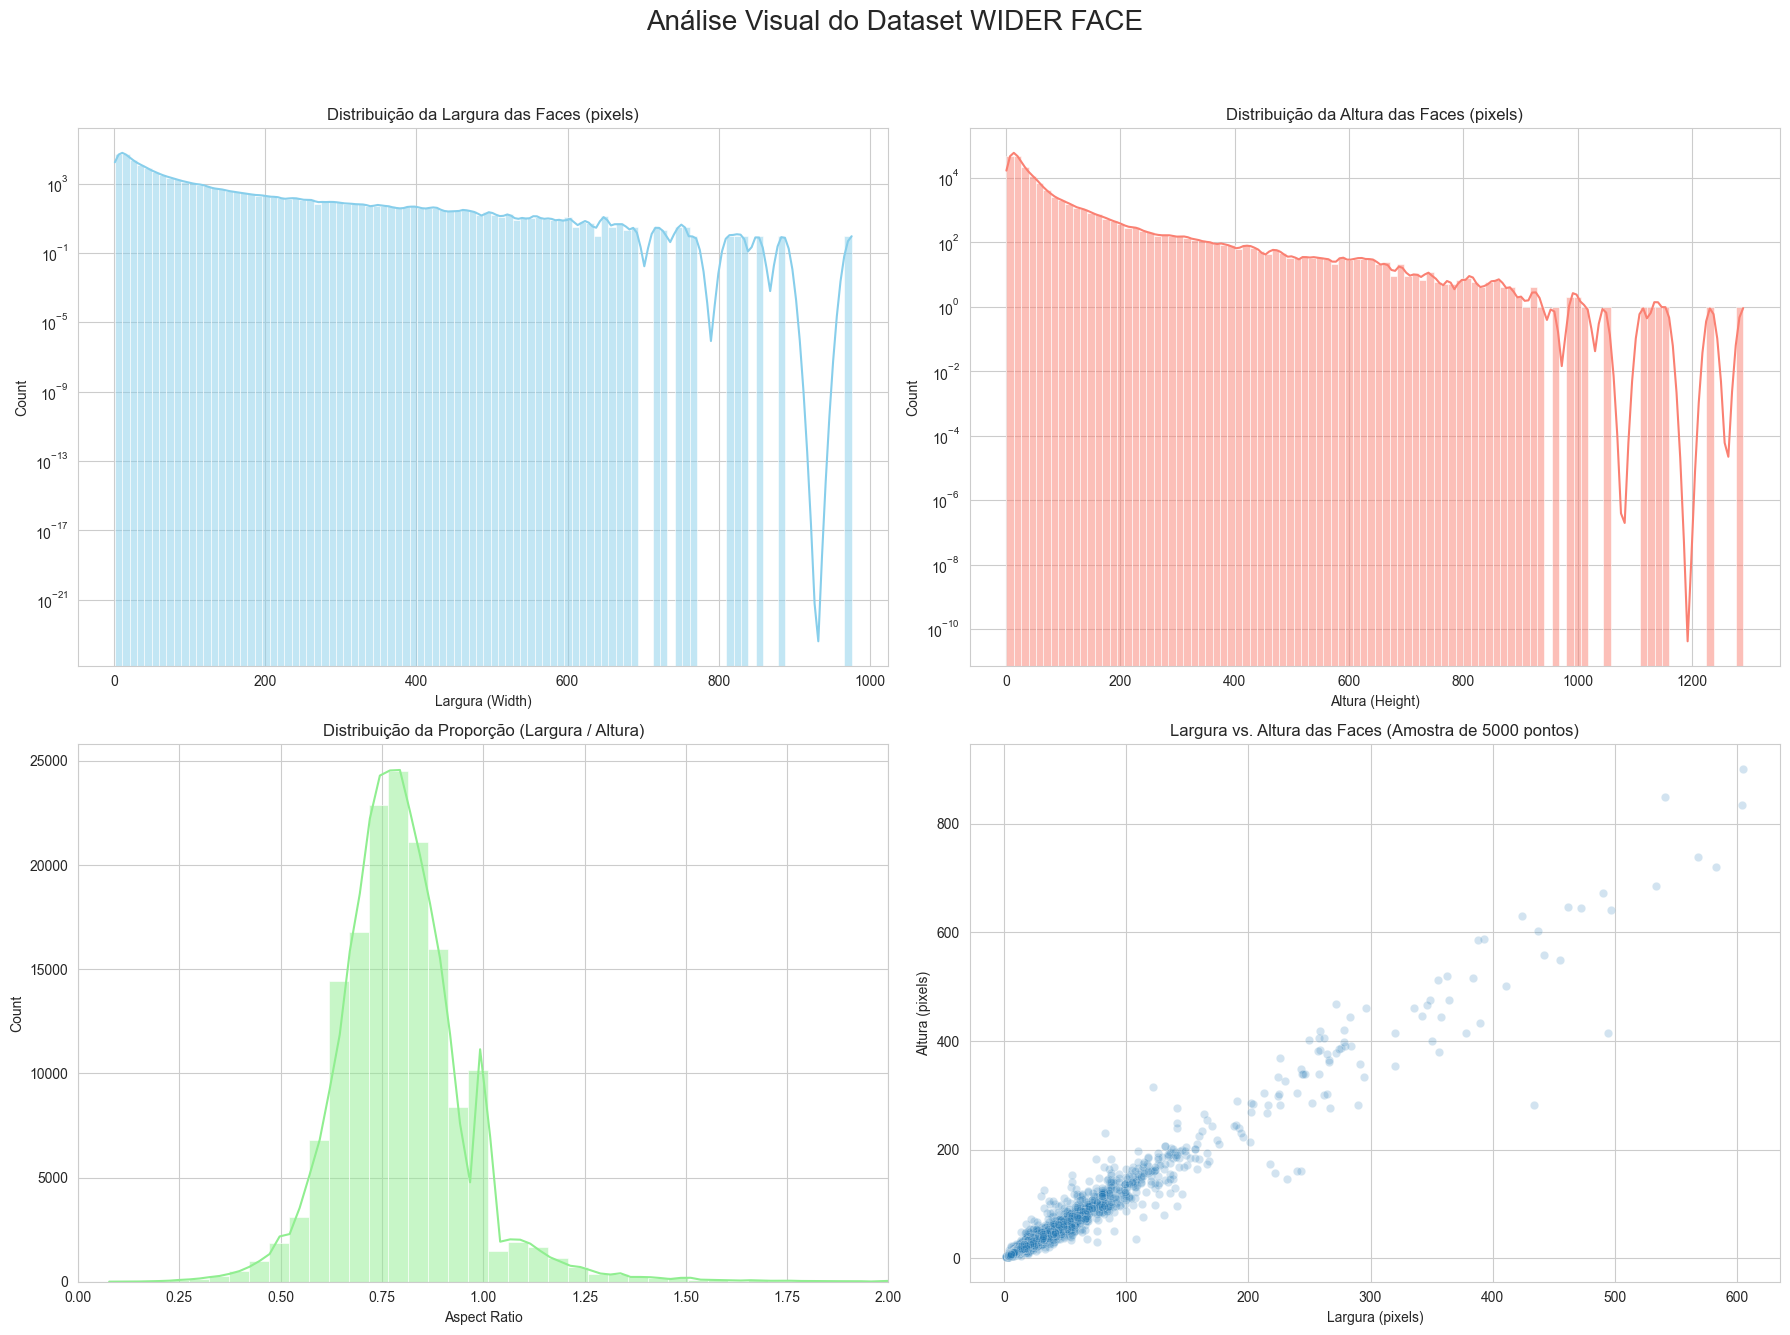

In [ ]:
# Figura com 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Análise Visual do Dataset WIDER FACE', fontsize=20)

# 1. Histograma da Largura das Faces (com escala logarítmica)
sns.histplot(df['width_pixel'], bins=100, ax=axs[0, 0], color='skyblue', kde=True)
axs[0, 0].set_title('Distribuição da Largura das Faces (pixels)')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlabel('Largura (Width)')

# 2. Histograma da Altura das Faces (com escala logarítmica)
sns.histplot(df['height_pixel'], bins=100, ax=axs[0, 1], color='salmon', kde=True)
axs[0, 1].set_title('Distribuição da Altura das Faces (pixels)')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xlabel('Altura (Height)')

# 3. Histograma da Proporção (Aspect Ratio)
sns.histplot(df['aspect_ratio'], bins=100, ax=axs[1, 0], color='lightgreen', kde=True)
axs[1, 0].set_title('Distribuição da Proporção (Largura / Altura)')
axs[1, 0].set_xlim(0, 2) # Limita o eixo X para melhor visualização
axs[1, 0].set_xlabel('Aspect Ratio')

# 4. Gráfico de Dispersão (Largura vs Altura)
sample_df = df.sample(n=min(5000, len(df)), random_state=42) # Amostra para performance
sns.scatterplot(data=sample_df, x='width_pixel', y='height_pixel', alpha=0.2, ax=axs[1, 1])
axs[1, 1].set_title('Largura vs. Altura das Faces (Amostra de 5000 pontos)')
axs[1, 1].set_xlabel('Largura (pixels)')
axs[1, 1].set_ylabel('Altura (pixels)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Análise dos Resultados e Insights

A análise estatística e gráfica revela padrões importantes sobre as faces no dataset WIDER FACE, que impactam diretamente as estratégias de treinamento do YOLOv8.  

### 4.1 Distribuição de Tamanhos: Predominância de Faces Pequenas
- **Observação:** Os histogramas de largura e altura (em escala logarítmica) mostram que a maioria das faces possui menos de 100 pixels, com médias em torno de 50–60 pixels.  
- **Insight:** O modelo lida majoritariamente com objetos pequenos.  
- **Ação:** Aumentar o parâmetro de resolução (`imgsz`) pode melhorar a detecção. Além do baseline em `640`, recomenda-se testar `imgsz=1280` para capturar melhor os detalhes das faces pequenas.

### 4.2 Proporção das Faces (Aspect Ratio)
- **Observação:** O histograma de razão largura/altura apresenta um pico concentrado em torno de 0.8.  
- **Insight:** As faces tendem a ser ligeiramente mais altas do que largas, o que é coerente com expectativas antropométricas.  
- **Ação:** As âncoras geradas automaticamente pelo YOLOv8 provavelmente já se ajustam bem a essa distribuição, não havendo necessidade de ajuste manual complexo.

### 4.3 Variedade Contínua de Escalas
- **Observação:** O gráfico de dispersão mostra uma “nuvem” contínua de tamanhos, sem clusters bem definidos.  
- **Insight:** O modelo precisa lidar com grande diversidade de escalas.  
- **Ação:** Técnicas de data augmentation, em especial o `mosaic`, são fundamentais para aumentar a robustez do treinamento frente a diferentes dimensões de face.

---

## 5. Conclusão e Próximos Passos

O desafio central do WIDER FACE é a **detecção multiescala, com predominância de objetos pequenos**. As decisões de treinamento devem priorizar a preservação da resolução e a robustez frente a variações de tamanho.  

**Próxima etapa:**  
- Baseline:  
  ```bash
  yolo detect train data=data/widerface.yaml model=yolov8n.pt epochs=100 imgsz=640


##  Análise das labels

In [2]:
df_numerical = pd.read_csv('wider_face_train_attributes.csv')
df_numerical.head()

,file_name,x1,y1,w,h,blur,expression,illumination,invalid,occlusion,pose
0,0--Parade/0_Parade_marchingband_1_849.jpg,449,330,122,149,0,0,0,0,0,0
1,0--Parade/0_Parade_Parade_0_904.jpg,361,98,263,339,0,0,0,0,0,0
2,0--Parade/0_Parade_marchingband_1_799.jpg,78,221,7,8,2,0,0,0,0,0
3,0--Parade/0_Parade_marchingband_1_799.jpg,78,238,14,17,2,0,0,0,0,0
4,0--Parade/0_Parade_marchingband_1_799.jpg,113,212,11,15,2,0,0,0,0,0


In [3]:
df_numerical.describe()

,x1,y1,w,h,blur,expression,illumination,invalid,occlusion,pose
count,159420.000000,159420.000000,159420.000000,159420.000000,159420.000000,159420.000000,159420.000000,159420.000000,159420.000000,159420.000000
mean,494.491475,285.731188,28.948846,37.399592,1.458079,0.011573,0.051022,0.015048,0.622820,0.037900
std,275.831434,215.094930,46.268656,61.105763,0.730869,0.106955,0.220044,0.121745,0.826541,0.190955
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,266.000000,150.000000,9.000000,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,488.000000,256.000000,15.000000,20.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,722.000000,375.000000,30.000000,38.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1050.000000,8717.000000,976.000000,1289.000000,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000


## Análise de distribuições

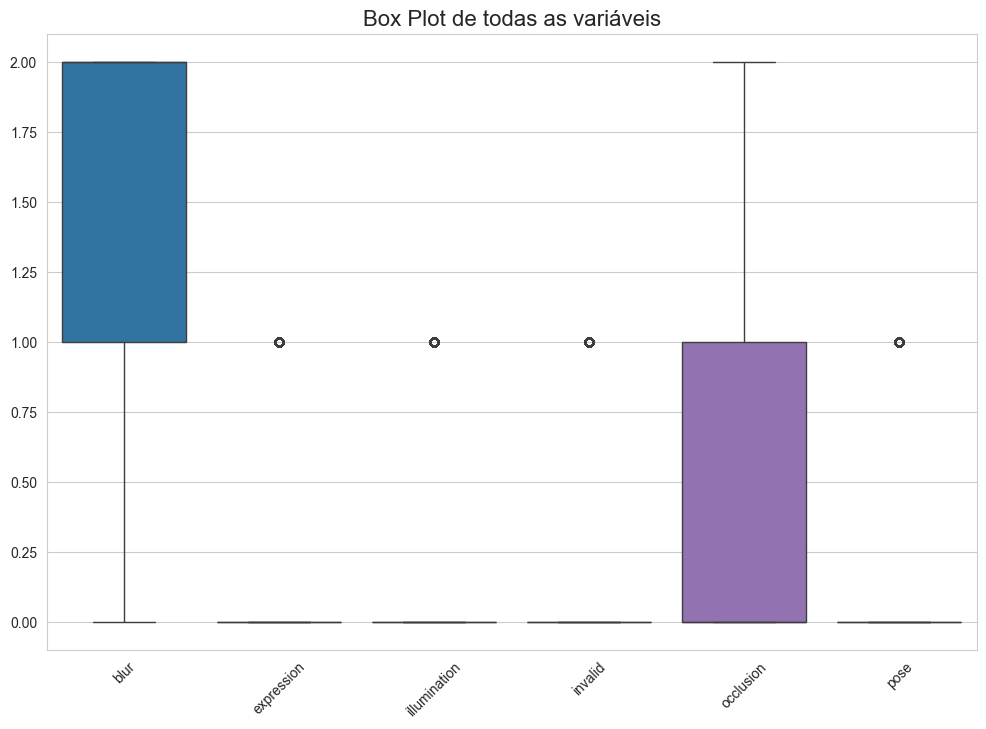

In [24]:
# 2. Select all columns except 'x1' and 'y1'
columns_to_plot = df_numerical.drop(columns=['x1', 'y1','w','h'])

# 3. Create a figure for the plot
plt.figure(figsize=(12, 8))

# 4. Generate the box plot for the selected data
sns.boxplot(data=columns_to_plot)

# 5. Set the title and rotate x-axis labels for better readability
plt.title('Box Plot de todas as variáveis', fontsize=16)
plt.xticks(rotation=45) # Rotates the column names on the x-axis

# 6. Display the plot
plt.show()

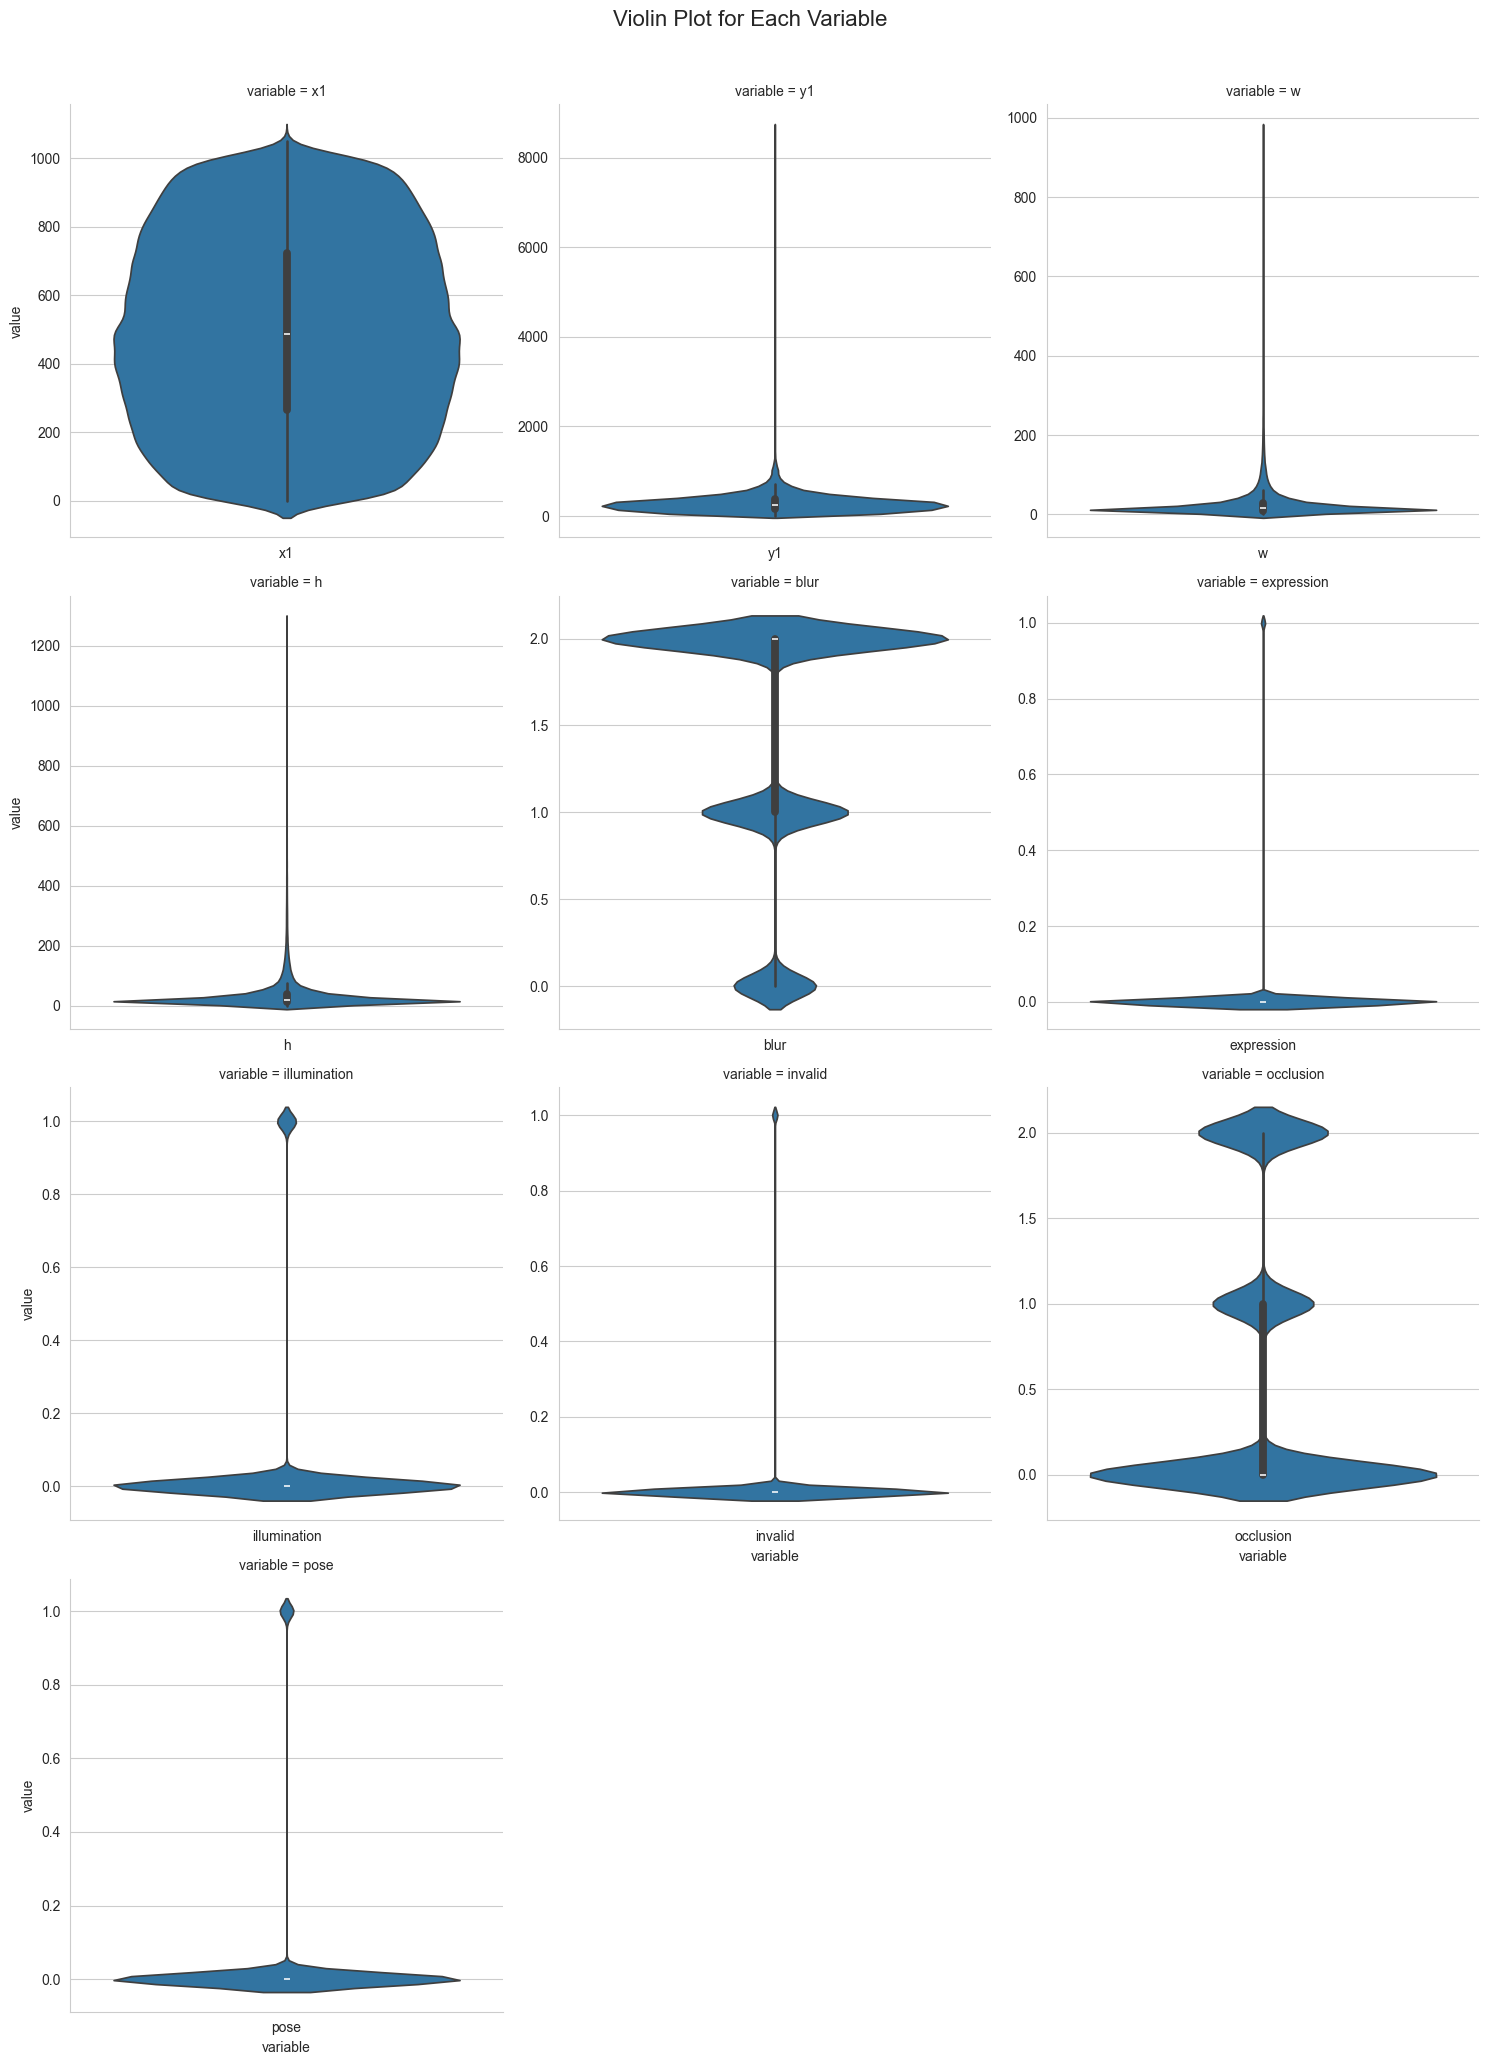

In [22]:

# 1. Define columns to drop. Using errors='ignore' makes it safe
#    even if a column doesn't exist in the DataFrame.
cols_to_drop = [ 'file_name']
df_for_plotting = df_numerical.drop(columns=cols_to_drop, errors='ignore')


# 2. Reshape the data from wide to long format for plotting
df_melted = df_for_plotting.melt(var_name='variable', value_name='value')


# 3. Create the violin plots using sns.catplot
# This creates a separate subplot for each variable with its own y-axis scale.
g = sns.catplot(data=df_melted, 
                x='variable', 
                y='value', 
                kind='violin', 
                col='variable',
                col_wrap=3, 
                sharey=False, 
                sharex=False)

g.fig.suptitle('Violin Plot for Each Variable', y=1.03, fontsize=16)
plt.show()


# Análise Preditiva das Distribuições das Variáveis Qualitativas

Com base na definição de cada variável de anotação do dataset, podemos antecipar a forma esperada de suas distribuições e, mais importante, entender quais insights práticos um gráfico de cada uma delas nos forneceria. Esta análise nos ajuda a quantificar o "perfil de dificuldade" do nosso conjunto de dados.

---

### Variável: `invalid`

* **O que esperamos da distribuição:** Sendo uma *flag* (booleana), esperamos uma distribuição com apenas dois valores possíveis: `0` (para rostos válidos) e `1` (para rostos inválidos). Não haverá nenhum outro valor no gráfico.

* **O que o gráfico nos diz:** A principal informação que o gráfico nos dá é a **proporção entre rostos válidos e inválidos**. Esperamos que a esmagadora maioria das anotações seja válida (`invalid = 0`). Se o gráfico mostrasse uma contagem alta de rostos inválidos, isso seria um alerta sobre a qualidade geral dos dados, indicando que uma porcentagem significativa das anotações é, na verdade, "lixo" que deveria ser filtrado antes do treinamento para não prejudicar o modelo.

---

### Variáveis: `occlusion` e `blur`

* **O que esperamos da distribuição:** Estas são variáveis categóricas ordinais, representando níveis de dificuldade (ex: `0` para nenhuma oclusão, `1` para parcial, `2` para pesada). Portanto, esperamos um gráfico de barras discreto, com valores concentrados apenas nesses números inteiros.

* **O que o gráfico nos diz:** O gráfico revela o **perfil de desafio** do dataset para estes quesitos. Em um dataset "in-the-wild" como o WIDER Face, é natural esperar uma distribuição assimétrica, com a maior contagem na categoria mais fácil (`0 - nenhuma oclusão/blur`), seguida por uma contagem menor na categoria intermediária e uma contagem bem pequena na categoria mais difícil. Se o gráfico mostrasse que a categoria "pesada" é a mais frequente, isso significaria que o dataset foi especificamente construído para ser extremamente desafiador naquele aspecto em particular.

---

### Variáveis: `pose`, `illumination` e `expression`

* **O que esperamos da distribuição:** Similarmente, estas são variáveis categóricas que representam estados (ex: `0` para pose típica, `1` para atípica). A distribuição será discreta, concentrada nos valores inteiros que representam essas categorias.

* **O que o gráfico nos diz:** O gráfico nos informa sobre o **balanço entre os casos "comuns" e os "casos de borda" (edge cases)**. É esperado que a maioria dos rostos tenha uma pose típica, iluminação normal e expressão comum. O gráfico quantifica exatamente essa proporção. Por exemplo, se 80% dos rostos tiverem iluminação normal e 20% tiverem iluminação extrema, sabemos que o modelo será treinado com uma frequência 4 vezes maior em cenários de boa luz. Essa informação é vital para planejar estratégias de aumento de dados (data augmentation), onde poderíamos, por exemplo, gerar artificialmente mais imagens com iluminação extrema para balancear o treinamento e tornar o modelo mais robusto.

Em resumo, a análise das distribuições dessas variáveis nos permite ir além do "ver os dados" e passar a **diagnosticar o viés e o perfil de dificuldade inerente ao dataset**, o que é fundamental para tomar decisões informadas sobre pré-processamento, treinamento e avaliação de modelos.

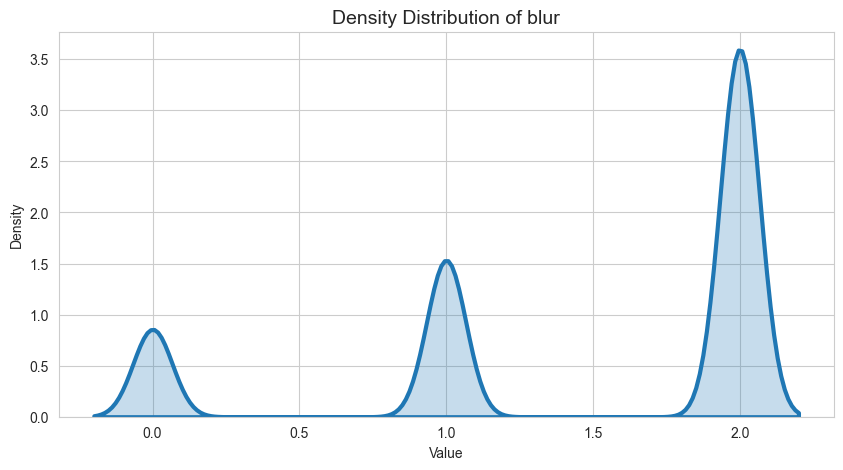

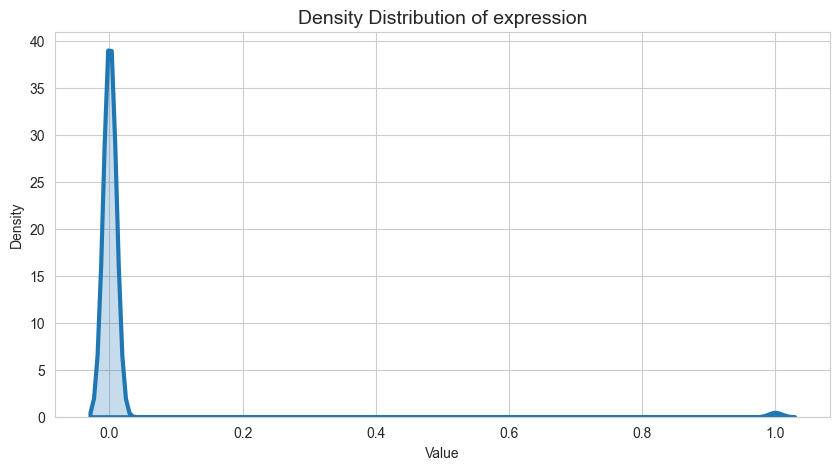

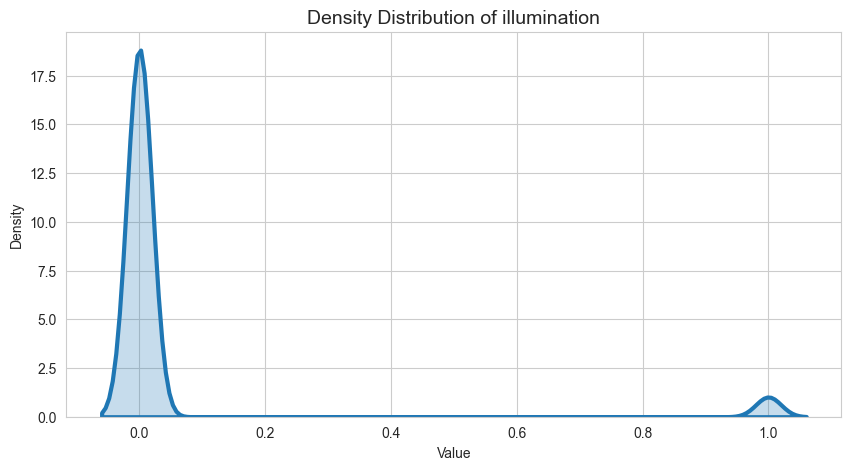

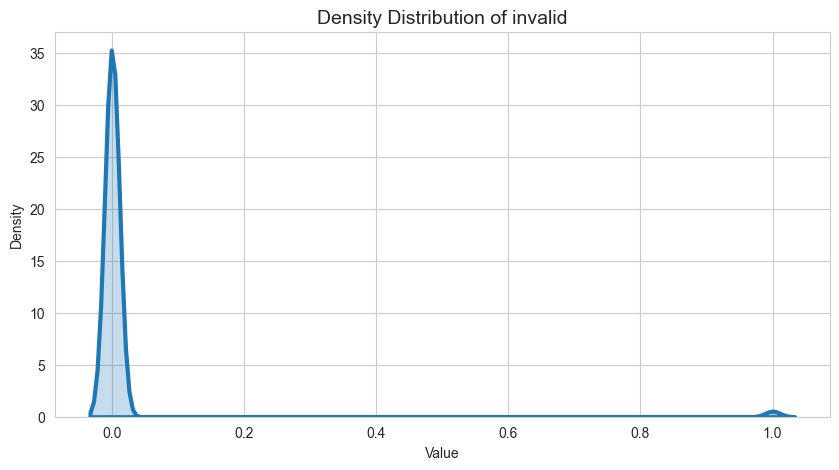

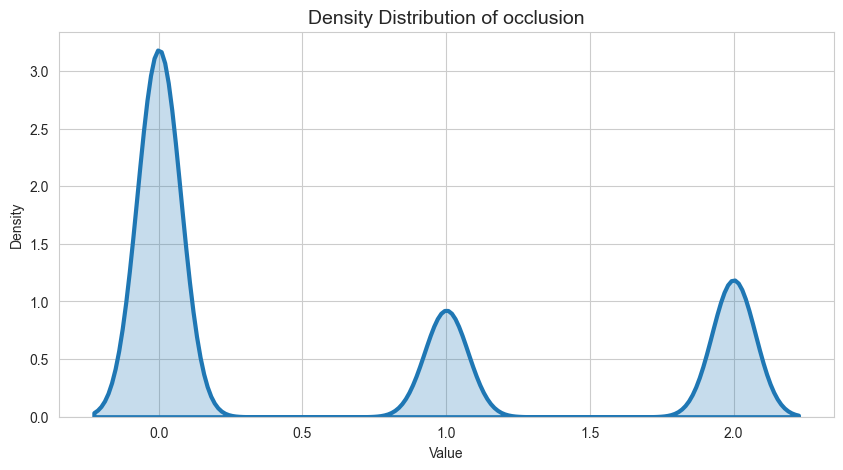

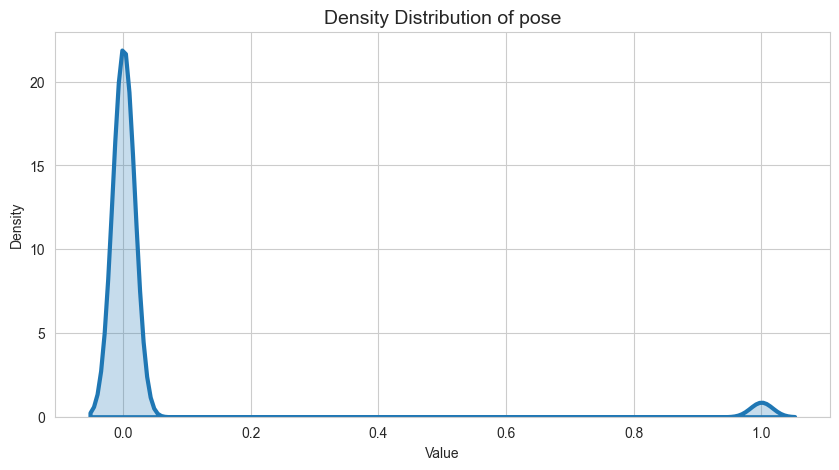

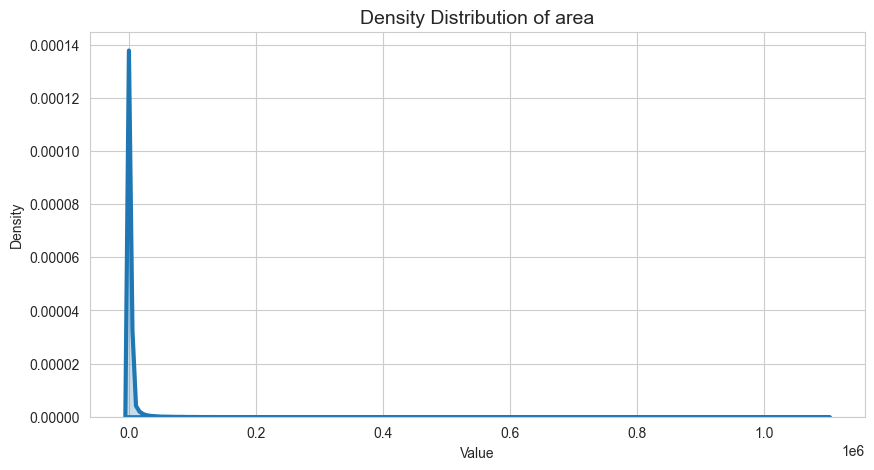

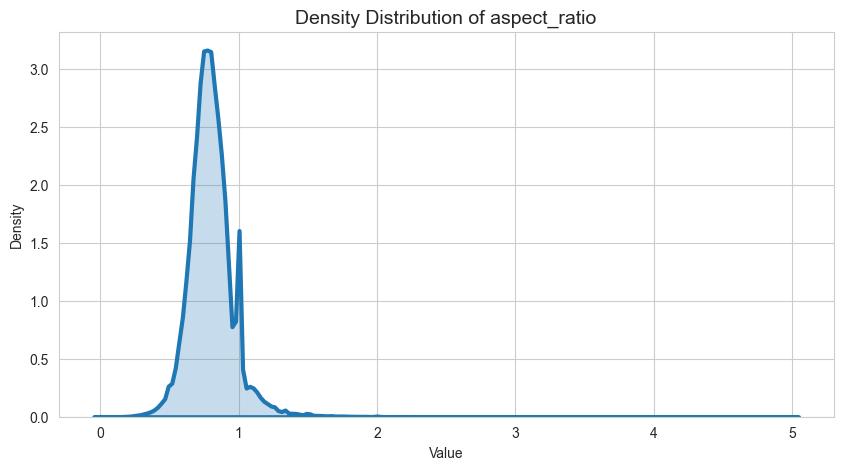

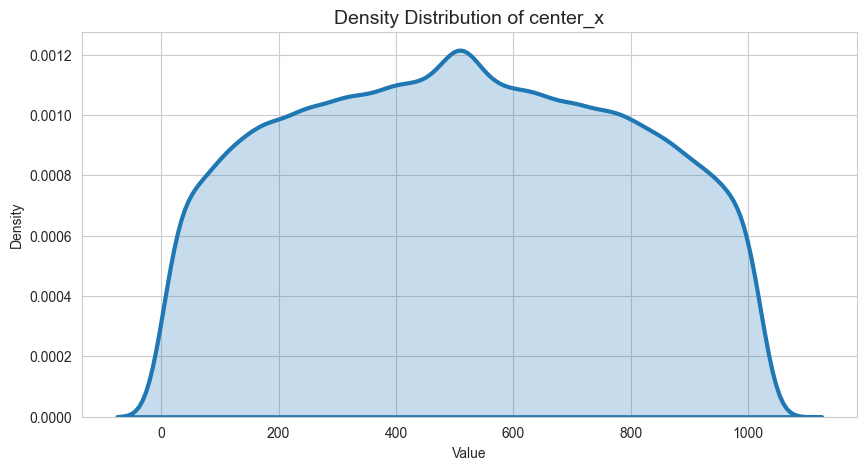

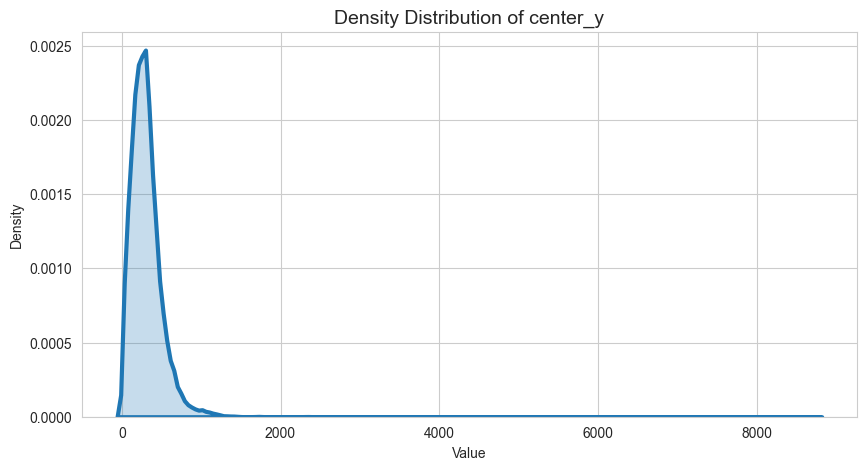

In [29]:
df_for_plotting = df_numerical.drop(columns=['file_name',"x1","y1","w","h"])


# 3. Loop through the columns of the new DataFrame
for col in df_for_plotting.columns:
    plt.figure(figsize=(10, 5))
    
    # Plot the KDE for the current column
    sns.kdeplot(data=df_for_plotting[col], fill=True, lw=3)
    
    # Set the title and labels
    plt.title(f'Density Distribution of {col}', fontsize=14)
    plt.xlabel('Value')
    plt.ylabel('Density')
    
    # Display the individual plot
    plt.show()


# Correlação das variáveis

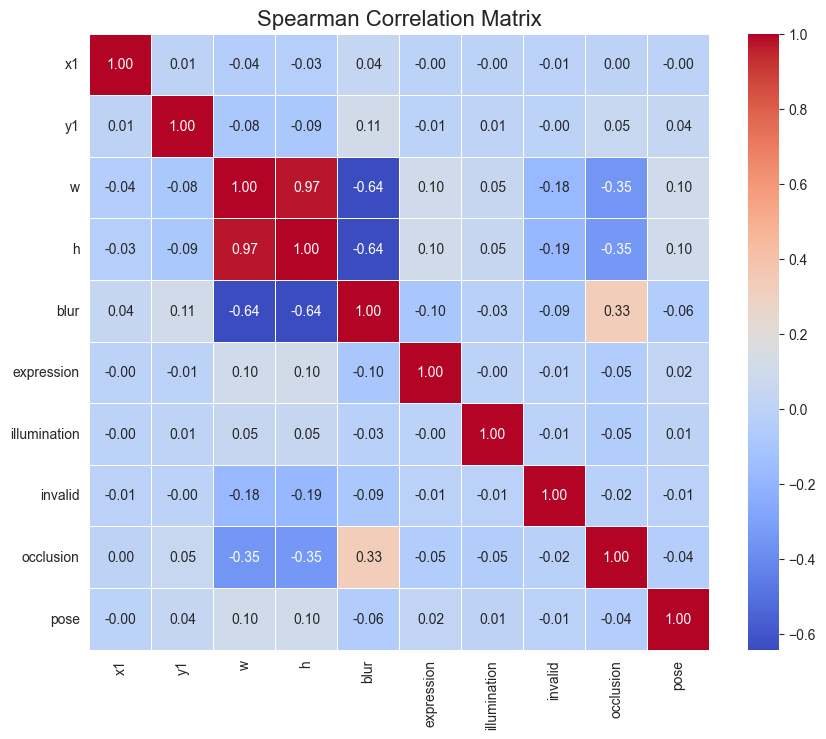

In [20]:


# 2. Drop the non-numerical 'file_name' column
df_for_corr = df_numerical.drop(columns=['file_name'])


# 3. Calculate the Spearman correlation matrix
corr_matrix = df_for_corr.corr(method='spearman')


# 4. Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5)
plt.title('Spearman Correlation Matrix', fontsize=16)
plt.show()

## Correlação de Spearman

Usamos a correlação de Spearman porque ela é mais **robusta** e não exige que os dados sigam uma distribuição "perfeita" (como a normal ou "curva de sino"). Em vez de usar os valores brutos dos dados, Spearman primeiro **ordena os dados** de cada variável (do menor para o maior) e depois mede o quão bem a ordem de uma variável se relaciona com a ordem da outra.

Isso a torna ideal para os seus dados por duas razões principais:

-  **Não se importa com outliers**: Um valor extremo não distorce o resultado, pois o que importa é sua posição na ordem, não o seu valor real.
-  **Detecta relações monotônicas**: Ela consegue capturar tendências de "quanto mais um sobe, mais o outro sobe (ou desce)", mesmo que essa relação não seja uma linha reta perfeita (que é o que a correlação de Pearson mede).

Em resumo, como notamos que suas distribuições são "estranhas", Spearman nos dá uma medida de correlação mais confiável e realista.

---

### 1. Correlação Positiva: `h` e `w` com 0.97

* Uma correlação de 0.97 é quase 1, o que indica uma relação positiva quase perfeita. À medida que a largura (`w`) de uma bounding box aumenta, a altura (`h`) também aumenta de forma extremamente previsível.
* **Por que isso acontece?** Isso é totalmente esperado e serve como uma **"verificação de sanidade"** para as anotações. Rostos humanos, independentemente do tamanho, mantêm uma proporção (aspect ratio) relativamente consistente. É muito raro um rosto ser extremamente largo e muito baixo, por exemplo. Essa correlação alta simplesmente confirma que as caixas de anotação seguem a geometria natural de um rosto.

### 2. Correlação Inversa: `blur` com `w` e `h` em -0.64

* Uma correlação negativa moderada (-0.64) indica que existe uma tendência inversa entre as variáveis. Ou seja, quanto **maior o `blur`** (borrão), **menor tendem a ser a largura e a altura** (`w` e `h`) do rosto.
* **Por que isso acontece?** Esta é a descoberta mais interessante e provavelmente revela um padrão na forma como as fotos do dataset foram tiradas:
    * **Rostos pequenos** (`w` e `h` baixos) geralmente estão distantes da câmera ou no fundo de uma cena. Elementos no fundo de uma foto têm uma chance muito maior de estarem fora de foco, resultando em um `blur` mais alto.
    * **Rostos grandes** (`w` e `h` altos) são, na maioria das vezes, o assunto principal da foto. Eles estão mais perto da câmera e o fotógrafo provavelmente focou neles, resultando em uma imagem mais nítida (menor `blur`).

### 3. Maioria dos dados não correlacionados

*  Valores de correlação próximos de zero (ex: entre -0.3 e 0.3) significam que não há uma relação discernível entre as variáveis. Saber o valor de uma não ajuda em nada a prever o valor da outra.
* **Por que isso acontece?** Na verdade, isso é algo bom e esperado. Significa que as diferentes "dificuldades" do dataset são independentes e representam a complexidade do mundo real. Por exemplo:
    * A **pose** de um rosto não tem relação com a **iluminação**. Um rosto pode estar de perfil com boa luz ou de perfil com luz ruim.
    * A **oclusão** não tem relação com a **expressão**. Uma pessoa pode estar sorrindo com óculos escuros ou com o rosto totalmente visível.
* Essa falta de correlação mostra que o dataset é **rico e diverso**, pois ele combina os diferentes desafios de forma aleatória, assim como acontece na realidade. Se todas as dificuldades fossem correlacionadas, o dataset teria um "viés" (bias) e não prepararia bem um modelo para todas as situações possíveis.

## Análise das bounding boxes

c:\Users\vncsb\Nova pasta\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


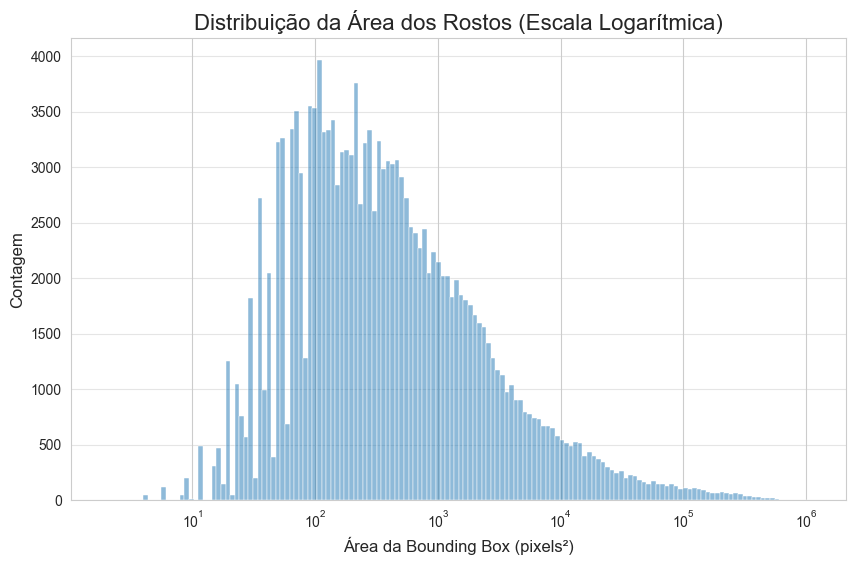

In [25]:
# 1. Calcular a área de cada bounding box
df_numerical['area'] = df_numerical['w'] * df_numerical['h']

# 2. Criar o plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_numerical, x='area', log_scale=True, kde=True)

# 3. Adicionar títulos e labels
plt.title('Distribuição da Área dos Rostos (Escala Logarítmica)', fontsize=16)
plt.xlabel('Área da Bounding Box (pixels²)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

A implicação prática mais significativa de toda a análise é a confirmação de que a principal dificuldade deste dataset reside na detecção de rostos pequenos e de baixa qualidade. O histograma da área das faces demonstrou inequivocamente que a esmagadora maioria dos exemplos possui dimensões reduzidas, muitas vezes na faixa de 10x10 a 32x32 pixels. Essa descoberta foi diretamente corroborada pela matriz de correlação, que revelou uma tendência moderadamente forte de que quanto menor o rosto, maior o nível de `blur` (borrão). Portanto, qualquer modelo de sucesso não pode apenas ser bom em encontrar objetos pequenos; ele precisa ser excepcionalmente robusto para identificá-los mesmo quando os detalhes visuais estão degradados e fora de foco.

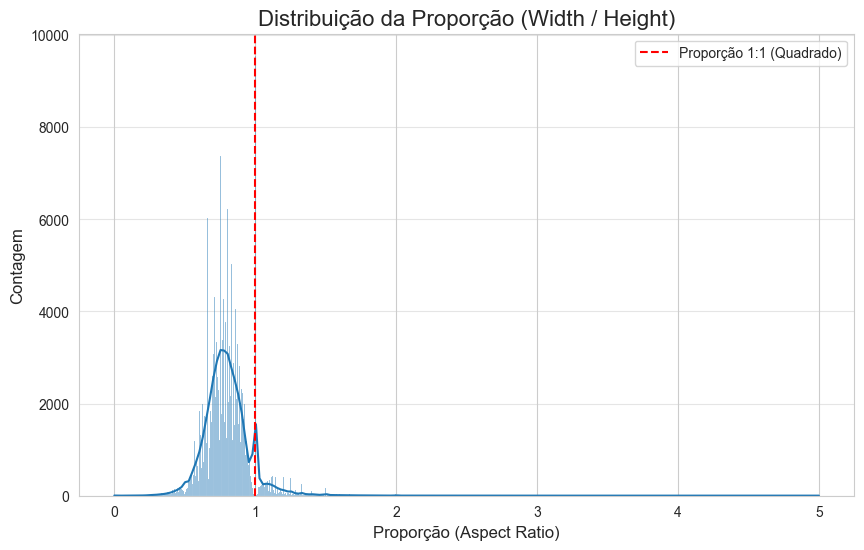

In [26]:
# 1. Calcular a proporção (aspect ratio)
df_numerical['aspect_ratio'] = df_numerical['w'] / df_numerical['h']

# 2. Criar o plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df_numerical, x='aspect_ratio', kde=True)

# 3. Adicionar uma linha vertical em x=1 para referência
plt.axvline(1, color='red', linestyle='--', label='Proporção 1:1 (Quadrado)')
plt.legend()

# 4. Adicionar títulos e labels
plt.title('Distribuição da Proporção (Width / Height)', fontsize=16)
plt.xlabel('Proporção (Aspect Ratio)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

### Análise da Distribuição da Proporção dos Rostos

Este gráfico ilustra a distribuição da forma das caixas de anotação (bounding boxes) através da sua proporção (aspect ratio). A análise revela uma concentração extremamente alta e aguda de dados em torno de uma proporção de 0.8 a 0.9, indicando que a grande maioria dos rostos no dataset está contida em caixas um pouco mais altas do que largas. Esta conformação é totalmente consistente com a geometria natural de um rosto humano em pose frontal, o que confere um alto grau de confiança na consistência da maioria das anotações.

Adicionalmente, a longa e baixa cauda que se estende para a direita do pico principal aponta para a existência de um pequeno número de casos atípicos. Estes são exemplos raros de anotações muito mais largas do que altas, que podem indicar poses incomuns, como uma pessoa deitada, ou até mesmo potenciais erros de anotação. Em suma, o gráfico demonstra um dataset com anotações majoritariamente consistentes e realistas, ao mesmo tempo que sinaliza a presença de outliers que poderiam ser investigados para garantir a qualidade total dos dados.

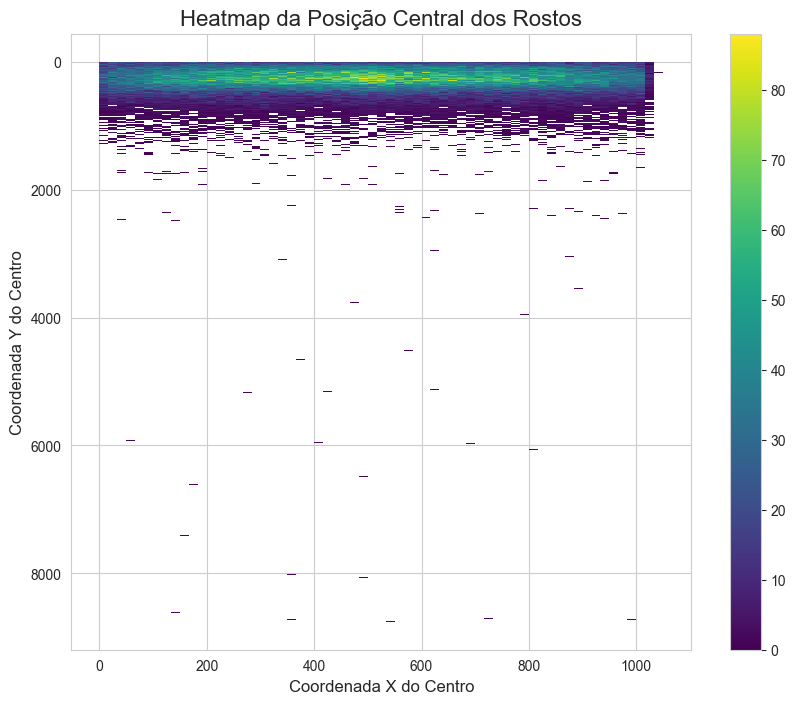

In [27]:
# 1. Calcular o centro de cada bounding box
df_numerical['center_x'] = df_numerical['x1'] + df_numerical['w'] / 2
df_numerical['center_y'] = df_numerical['y1'] + df_numerical['h'] / 2

# 2. Criar o plot de heatmap 2D
plt.figure(figsize=(10, 8))
sns.histplot(data=df_numerical, x='center_x', y='center_y', cmap='viridis', cbar=True)

# 3. Adicionar títulos e labels
plt.title('Heatmap da Posição Central dos Rostos', fontsize=16)
plt.xlabel('Coordenada X do Centro', fontsize=12)
plt.ylabel('Coordenada Y do Centro', fontsize=12)
# Inverter o eixo Y para que a origem (0,0) fique no canto superior esquerdo, como em imagens
plt.gca().invert_yaxis()
plt.show()

# Análise do Heatmap de Posição dos Rostos

Este heatmap é uma representação visual da densidade dos centros das faces (`center_x`, `center_y`) em todas as imagens do dataset. Ele nos ajuda a entender se existem padrões ou vieses na localização dos rostos dentro das fotografias. Os eixos X e Y correspondem às coordenadas de pixel, e as cores indicam a frequência de rostos naquela região. Áreas com cores mais escuras, como azul, têm baixa densidade, enquanto áreas com cores mais claras e quentes, como **amarelo**, representam os **pontos de maior concentração**.

A interpretação deste gráfico geralmente revela uma forte concentração de rostos na porção central das imagens, manifestada por uma grande área amarela no meio do mapa. Este padrão é esperado e reflete um comportamento comum na fotografia, onde o assunto principal é centralizado no enquadramento. A conclusão prática mais importante derivada desta observação é a identificação de um **viés (bias) de localização**. Um modelo treinado neste conjunto de dados receberá muito mais exemplos de rostos no centro e, consequentemente, se tornará especialista em detectá-los nessa região. No entanto, essa mesma eficiência pode não se repetir para rostos localizados nas **bordas ou cantos da imagem**, onde o modelo teve menos oportunidades de aprendizado.

Portanto, o heatmap não apenas descreve onde os rostos estão, mas também nos alerta sobre as potenciais limitações de generalização de um modelo treinado com esses dados. Ele destaca as áreas da imagem onde a performance do detector pode ser mais fraca devido a um treinamento menos diverso em termos de posicionamento espacial dos objetos de interesse.